## PaleoSTeHM: A modern, scalable Spatio-Temporal Hierarchical Modeling framework for paleo-environmental data

Yucheng Lin - yc.lin@rutgers.edu

with Alex Reedy and Robert Kopp

### Application Example: Kopp et al., 2016 Temperature-driven global sea-level variability in the Common Era

In this notebook, we will try to replicate global sea-level change signal in Common Era.

In [1]:
#load modules
import matplotlib.pyplot as plt
import matplotlib
import torch
import numpy as np
import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import cartopy
import cartopy.crs as ccrs
import sys
import nmmn.plots
import os
import zipfile

sys.path.append('../Code')
import PSTHM 
import time
parula=nmmn.plots.parulacmap() # for MATLAB's cmap

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo
assert pyro.__version__.startswith('1.8.4')

#set plotting style
%matplotlib inline
font = {'weight':'normal',
       'size':20}

matplotlib.rc('font',**font)
matplotlib.rcParams['figure.figsize'] = (12, 6)
import warnings
warnings.filterwarnings("ignore")

#### 1. Load and preprocess all sea-level data 

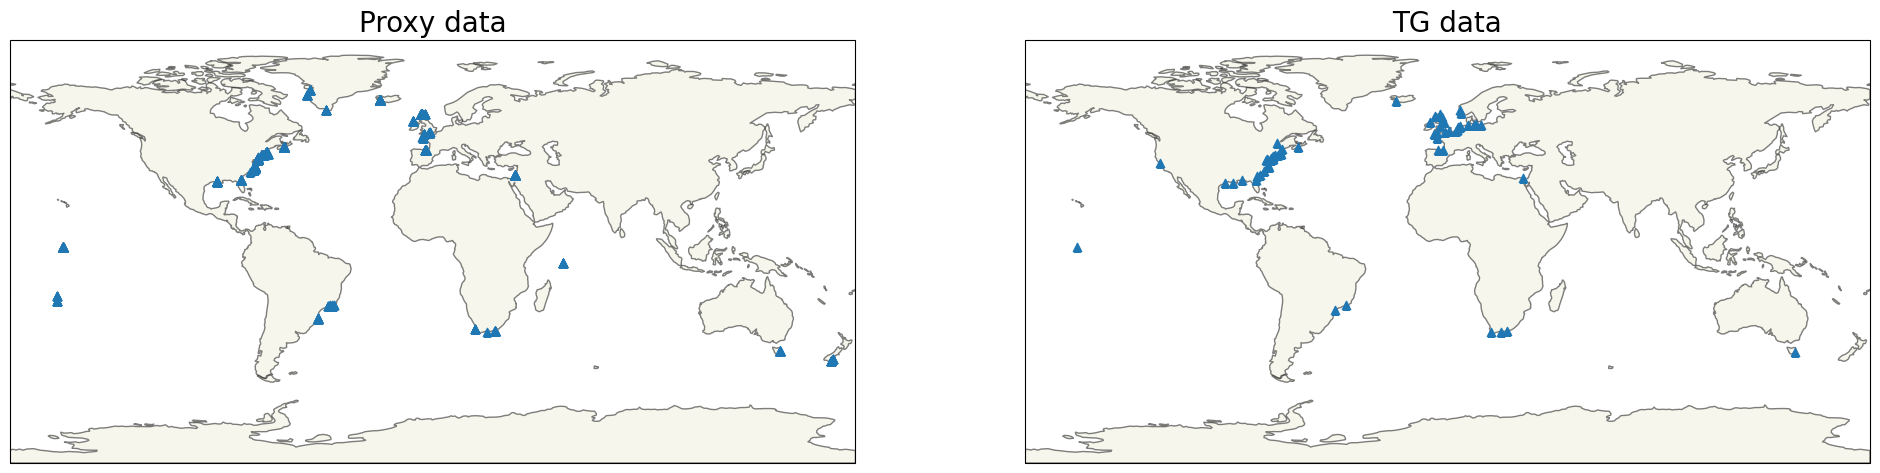

In [2]:
#load the proxy data
proxy_data = pd.read_csv('IFILES/RSL_All_30Dec2015.csv')
trainfirsttime = -1000
proxy_data = proxy_data[proxy_data['Age (CE)']>trainfirsttime]

TG_ID = pd.read_excel('IFILES/TG_ID.xlsx',skiprows=np.arange(1,4))

TG_data_folder = '../Data/TG_data/'

if len(os.listdir(TG_data_folder))<5:
    with zipfile.ZipFile(TG_data_folder+'TG_data.zip', 'r') as zip_ref:
        zip_ref.extractall(TG_data_folder)
site_file = pd.read_table(TG_data_folder+'/filelist.txt',delimiter=';',header=None)
selection_index = np.array([i in list(TG_ID['PSMSL ID']) for i in site_file.iloc[:,0]])
selected_sites = site_file.iloc[selection_index,:]

plt.figure(figsize=(24,10))
ax2 = plt.subplot(121,projection=ccrs.PlateCarree())
ax2.set_global()
ax2.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax2.scatter(proxy_data['Longitude (E)'],proxy_data['Latitude (N)'],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax2.set_title('Proxy data',fontsize=20)

ax1 = plt.subplot(122,projection=ccrs.PlateCarree())
ax1.set_global()
ax1.add_feature(cartopy.feature.LAND,edgecolor='black',zorder=0,alpha=0.5)
ax1.scatter(selected_sites.iloc[:,2],selected_sites.iloc[:,1],transform=ccrs.PlateCarree(),zorder=1,
            marker='^')
ax1.set_title('TG data',fontsize=20);

**Load results from Hay et al., 2015**

In [14]:
import scipy.io as sio
gslfile = os.path.join('IFILES', 'Hay2015_KFandGP_GMSL.mat')

Haydat = sio.loadmat(gslfile)
Hay = {}

Hay['Y'] = Haydat['KF_GMSL'][0]
Hay['dY'] = np.sqrt(np.diag(Haydat['KF_GMSL_var']))
Hay['Ycv'] = Haydat['KF_GMSL_var']
Hay['datid'] = np.zeros_like(Hay['Y'])
Hay['time1'] = Haydat['tt_KF'][:]
Hay['time2'] = Hay['time1']
Hay['meantime'] = Hay['time1']
Hay['lat'] = np.ones_like(Hay['Y']) * 1e6
Hay['long'] = Hay['lat']
Hay['compactcorr'] = np.zeros_like(Hay['Y'])
Hay['limiting'] = np.zeros_like(Hay['Y'])
Hay['istg'] = np.ones_like(Hay['Y'])
Hay['siteid'] = 0
Hay['sitenames'] = ['Hay_KF_GMSL']
Hay['sitecoords'] = [1e6, 1e6]
Hay['sitelen'] = len(Hay['Y'])

# Smooth Hay et al curve
Hayavgwin = 10
Haystep = 10
HayGSL = Hay.copy()
HayGSL['time1'] = np.arange(1885, 2006, Haystep)
HayGSL['time2'] = HayGSL['time1']
HayGSL['meantime'] = HayGSL['time1']
M = np.abs(np.subtract.outer(HayGSL['time1'], Hay['time1'])) <= (Hayavgwin / 2)
M = M[:,0,:]
M = M / np.sum(M, axis=1, keepdims=True)
HayGSL['Y'] = M @ Hay['Y']
HayGSL['Ycv'] = M @ Hay['Ycv'] @ M.T
HayGSL['dY'] = np.sqrt(np.diag(HayGSL['Ycv']))
HayGSL['datid'] = np.zeros_like(HayGSL['Y'])
HayGSL['lat'] = np.ones_like(HayGSL['Y']) * 1e6
HayGSL['long'] = HayGSL['lat']
HayGSL['compactcorr'] = np.zeros_like(HayGSL['Y'])
HayGSL['limiting'] = np.zeros_like(HayGSL['Y'])
HayGSL['istg'] = np.ones_like(HayGSL['Y'])


**Pseudo data so that average rate of change between -100 to 100 CE and 1600-1800 CE is close to zero**

In [15]:
GSLflattener = {}
GSLflattener['sigma'] = 1e4
GSLflattener['time1'] = 0.01 + np.concatenate((np.arange(-100, 101, 50), np.arange(1600, 1801, 50)))
GSLflattener['Y'] = np.zeros_like(GSLflattener['time1'])
GSLflattener['Ycv'] = np.ones((len(GSLflattener['Y']), len(GSLflattener['Y']))) * (GSLflattener['sigma']**2)

GSLflattener['Ycv'][:5, :5] += ((0.0025 * 1700)**2 + np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)
GSLflattener['Ycv'][5:10, 5:10] += (np.eye(5) * GSLflattener['sigma']**2 - GSLflattener['sigma']**2 / 5)

GSLflattener['dY'] = np.sqrt(np.diag(GSLflattener['Ycv']))
GSLflattener['datid'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['time2'] = GSLflattener['time1']
GSLflattener['meantime'] = GSLflattener['time1']
GSLflattener['lat'] = np.ones_like(GSLflattener['Y']) * 1e6
GSLflattener['long'] = GSLflattener['lat']
GSLflattener['compactcorr'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['limiting'] = np.zeros_like(GSLflattener['Y'])
GSLflattener['istg'] = np.ones_like(GSLflattener['Y'])
GSLflattener['siteid'] = 0
GSLflattener['sitenames'] = ['GSLflattener']
GSLflattener['sitecoords'] = [1e6, 1e6]
GSLflattener['sitelen'] = len(GSLflattener['Y'])


**Load three old TG data**

In [16]:
import os
from scipy.sparse import dia_matrix

# old tide gauges

TGold = {
    'datid': [],
    'meantime': [],
    'Y': [],
    'dY': [],
    'lat': [],
    'long': [],
    'siteid': [],
    'sitenames': [],
    'sitecoords': [],
    'sitelen': [],
    'time1': [],
    'time2': [],
    'limiting': [],
    'compactcorr': [],
    'istg': [],
    'Ycv': None
}

for ppp in range(1, 4):
    if ppp == 1:
        dat = pd.read_csv(os.path.join('IFILES', 'amsterdam.sea.level.txt'), delim_whitespace=True,header=None)
        wsite = 'AMSTERDAM_OLD'
        wcurid = 5001
        wlat = [52.3667]
        wlong = [4.9000]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 1].values
    elif ppp == 2:
        dat = pd.read_csv(os.path.join('IFILES', 'Kronstadt_ReportsFGI_Bogdanov_appendix.csv'))
        wsite = 'KRONSTADT_OLD'
        wcurid = 5002
        wlat = [59.98]
        wlong = [29.77]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values
    elif ppp == 3:
        dat = pd.read_csv(os.path.join('IFILES', 'ekman_2003_stockholm.csv'),skiprows=1)
        wsite = 'STOCKHOLM_OLD'
        wcurid = 5003
        wlat = [59.32]
        wlong = [18.08]
        wdatid = np.ones(len(dat)) * wcurid
        wtime = dat.iloc[:, 0].values
        wY = dat.iloc[:, 2].values

    TGold['datid'].extend(wdatid)
    TGold['meantime'].extend(wtime)
    TGold['Y'].extend(wY)
    TGold['dY'] = np.ones(len(TGold['Y'])) * 3
    TGold['lat'].extend(np.ones_like(wY) * wlat)
    TGold['long'].extend(np.ones_like(wY) * wlong)
    TGold['siteid'].extend(np.ones_like(wY) * wcurid)
    TGold['sitenames'].append(wsite)
    TGold['sitecoords'].append([wlat[0], wlong[0]])
    TGold['sitelen'].append(len(wY))

TGold['time1'] = TGold['meantime']
TGold['time2'] = TGold['meantime']
TGold['limiting'] = np.zeros_like(TGold['datid'])
TGold['compactcorr'] = np.zeros_like(TGold['datid'])
TGold['istg'] = np.ones_like(TGold['datid'])
TGold['Ycv'] = dia_matrix((TGold['dY']**2, 0), shape=(len(TGold['Y']), len(TGold['Y'])))


**Smoothing TG data with decadal average**

In [17]:
# for idx,i in enumerate(selected_sites.iloc[:,0]):
#     #fit temporal GP to each TG
#     tem_rsl_data = pd.read_table(TG_data_folder+str(i)+'.rlrdata',delimiter=';',header=None)
#     data_filter = tem_rsl_data.iloc[:,1]!=-99999
#     data_filter_2 = tem_rsl_data.iloc[:,2]=='N'
#     data_filter_3 = tem_rsl_data.iloc[:,3]==0
#     data_filter_all = data_filter & data_filter_2 & data_filter_3
#     pyro.clear_param_store()
#     M32_kernel = gp.kernels.Matern32(input_dim=1)
#     M32_kernel.set_prior('variance', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))
#     M32_kernel.set_prior('lengthscale', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))

#     TG_noise = torch.ones(len(tem_rsl_data.iloc[:,0][data_filter_all].values))*3.**2
#     GPR = PSTHM.GPRegression_V(torch.tensor(tem_rsl_data.iloc[:,0][data_filter_all].values),torch.tensor(tem_rsl_data.iloc[:,1][data_filter_all].values),M32_kernel,noise = TG_noise)
#     GPR,track_list = PSTHM.SVI_optm(GPR,num_iteration=1000,lr=0.1)
    
#     min_age = tem_rsl_data.iloc[:,0][data_filter_all].min()//10 *10
#     max_age = (tem_rsl_data.iloc[:,0][data_filter_all].max()//10) *10
#     testing_x = np.arange(min_age,max_age+1,1)
#     mean,cov = GPR(torch.tensor(testing_x))
#     mean = mean.detach().numpy()
#     std = cov.sqrt().detach().numpy()
#     #calculate reference RSL at year 2000 by linear regression
#     lr_cof = np.polyfit(tem_rsl_data.iloc[:,0][data_filter_all],tem_rsl_data.iloc[:,1][data_filter_all],1)
#     ref_RSL = lr_cof[0]*2000 + lr_cof[1]
#     #calculate decadal average
#     decadal_x = np.array([np.mean(testing_x[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)]) 
#     decadal_mean = np.array([np.mean(mean[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)] )
#     decadal_mean_std = np.array([np.mean(std[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)])
#     #filter out nan values
#     non_index = np.isnan(decadal_mean)
#     decadal_mean = decadal_mean[~non_index] - ref_RSL
#     decadal_mean_std = decadal_mean_std[~non_index]
#     decadal_x = decadal_x[~non_index]
    
#     if i==1:
#         new_rsl_data= np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*selected_sites.iloc[idx,1],np.ones(len(decadal_mean))*selected_sites.iloc[idx,2],decadal_x,decadal_mean,decadal_mean_std]).T
#     else:
#         new_rsl_data = np.concatenate((new_rsl_data,np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*selected_sites.iloc[idx,1],np.ones(len(decadal_mean))*selected_sites.iloc[idx,2],decadal_x,decadal_mean,decadal_mean_std]).T),axis=0)
# new_rsl_data = pd.DataFrame(new_rsl_data,columns=['ID','Latitude','Longitude','Year (CE)','RSL (mm)','RSL std (mm)'])
# new_rsl_data.to_csv('IFILES/Decadal_TG.csv',index=False)
new_TG_rsl_data = pd.read_csv('IFILES/Decadal_TG.csv')

**Smoothing old TG data with decadal average**

In [18]:
# #Do GP regression for three sites
# old_TG_x = torch.tensor(TGold['meantime'])
# old_TG_y = torch.tensor(TGold['Y'])
# old_TG_x_sigma = torch.zeros_like(old_TG_x)
# old_TG_y_sigma = torch.tensor(TGold['dY'])

# for i in np.unique(TGold['datid']):
#     idx = TGold['datid'] == i
#     test_x = old_TG_x[idx]
#     test_y = old_TG_y[idx]
#     test_x_sigma = old_TG_x_sigma[idx]
#     test_y_sigma = old_TG_y_sigma[idx]
#     test_lon = np.array(TGold['long'])[idx][0]
#     test_lat = np.array(TGold['lat'])[idx][0]

#     pyro.clear_param_store()
#     M32_kernel = gp.kernels.Matern32(input_dim=1)
#     M32_kernel.set_prior('variance', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))
#     M32_kernel.set_prior('lengthscale', dist.Uniform(torch.tensor(30.), torch.tensor(1e6)))

#     GPR = PSTHM.GPRegression_V(test_x,test_y,M32_kernel,noise = test_y_sigma**2)
#     GPR,track_list = PSTHM.SVI_optm(GPR,num_iteration=1000,lr=0.1)

#     min_age = test_x.min()//10 *10
#     max_age = (test_x.max()//10) *10
#     testing_x = np.arange(min_age,max_age+1,1)
#     mean,cov = GPR(torch.tensor(testing_x))
#     mean = mean.detach().numpy()
#     std = cov.sqrt().detach().numpy()

#     #calculate decadal average
#     decadal_x = np.array([np.mean(testing_x[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)]) 
#     decadal_mean = np.array([np.mean(mean[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)] )
#     decadal_mean_std = np.array([np.mean(std[i2*10+1:(i2+1)*10]) for i2 in range(len(testing_x)//10 +1)])
#     #filter out nan values
#     non_index = np.isnan(decadal_mean)
#     decadal_mean = decadal_mean[~non_index] 
#     decadal_mean_std = decadal_mean_std[~non_index]
#     decadal_x = decadal_x[~non_index]

#     if i==5001:
#         old_TG_rsl_data= np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*test_lat,np.ones(len(decadal_mean))*test_lon,decadal_x,decadal_mean,decadal_mean_std]).T
#     else:
#         old_TG_rsl_data = np.concatenate((old_TG_rsl_data, np.array([np.ones(len(decadal_mean))*i,np.ones(len(decadal_mean))*test_lat,np.ones(len(decadal_mean))*test_lon,decadal_x,decadal_mean,decadal_mean_std]).T),axis=0)

# old_TG_rsl_data = pd.DataFrame(old_TG_rsl_data,columns=['ID','Latitude','Longitude','Year (CE)','RSL (mm)','RSL std (mm)'])
# old_TG_rsl_data.to_csv('IFILES/Decadal_old_TG.csv',index=False)
old_TG_rsl_data = pd.read_csv('IFILES/Decadal_old_TG.csv')

**Combine all data**


In [19]:
#combined proxy and TG data 

X = np.hstack((proxy_data['Age (CE)'],new_TG_rsl_data['Year (CE)'],old_TG_rsl_data['Year (CE)'],GSLflattener['meantime'],HayGSL['meantime']))
y = np.hstack((proxy_data['RSL (m)'],new_TG_rsl_data['RSL (mm)']/1000,old_TG_rsl_data['RSL (mm)']/1000,
                GSLflattener['Y']/1000,HayGSL['Y']/1000))
proxy_x_sigma = (proxy_data['Age +2s'] + proxy_data['Age -2s'])/4
X_sigma = np.hstack((proxy_x_sigma,np.zeros(len(new_TG_rsl_data)),np.zeros(len(old_TG_rsl_data)),
                    np.zeros(len(GSLflattener['meantime'])),np.zeros(len(HayGSL['meantime']))))

proxy_y_sigma = (proxy_data['RSL +1s'] + proxy_data['RSL -1s'])/2
y_sigma = np.hstack((proxy_y_sigma,new_TG_rsl_data['RSL std (mm)']/1000,
                    old_TG_rsl_data['RSL std (mm)']/1000,GSLflattener['dY']/1000,HayGSL['dY']/1000))

longitude = np.hstack([proxy_data['Longitude (E)'],new_TG_rsl_data['Longitude'],old_TG_rsl_data['Longitude'],
                    GSLflattener['long']/200,HayGSL['long']/2000])
longitude[longitude<0]+=360
latitude = np.hstack([proxy_data['Latitude (N)'],new_TG_rsl_data['Latitude'],old_TG_rsl_data['Latitude'],
                    GSLflattener['lat']/200,HayGSL['lat']/2000])

X_all = np.vstack([X,latitude,longitude]).T

#filter out data with too old age or too large uncertainty
filter_1 = (X<-1000) &(X>2010)
filter_2 = X_sigma>=100
filter_all = filter_1 | filter_2
X = X[~filter_all]
y = y[~filter_all]
X_sigma = X_sigma[~filter_all]
y_sigma = y_sigma[~filter_all]
X_all = X_all[~filter_all]
longitude = longitude[~filter_all]
latitude = latitude[~filter_all]


**Load ICE5G Model**

In [20]:
#load ICE5G
import netCDF4 as nc
nc = nc.Dataset('IFILES/dsea250.1grid.ICE5Gv1.3_VM2_L90_2012.nc')
lon = nc.variables['Lon'][:]
lat = nc.variables['Lat'][:]
Lon_mat,Lat_mat = np.meshgrid(lon,lat)
GIA = nc.variables['Dsea_250'][:]

#interpolate ICE5G linear rate to all sites
from scipy import interpolate
long_index = longitude<360

GIA_rate = interpolate.griddata(np.vstack([Lon_mat.flatten(),Lat_mat.flatten()]).T, GIA.flatten(), (longitude[long_index], latitude[long_index]), method='linear')

y_no_GIA = y.copy()
y_no_GIA[long_index] = y_no_GIA[long_index] - GIA_rate*(X[long_index]-2010)/1000

**Fit Spatio-temporal GP**

In [21]:
from tqdm.notebook import tqdm

def SVI_NI_optm(gpr,x_sigma,num_iteration=1000,lr=0.05,decay_r = 1,step_size=100,gpu=False):
    '''
    A funciton to optimize the hyperparameters of a GP model using SVI

    ---------Inputs-----------
    gpr: a GP model defined by pyro GPR regression
    x_sigma: one sigma uncertainty for input data
    num_iteration: number of iterations for the optimization
    lr: learning rate for the optimization
    step_size: step size for the learning rate to decay. 
    A step size of 100 with a decay rate of 0.9 means that the learning rate will be decrease 10% for every 100 steps.
    gpu: whether use gpu to accelerate training 
    ---------Outputs-----------
    gpr: a GP model with optimized hyperparameters
    track: a dictionary of loss
    '''
    
    #clear the param store
    pyro.clear_param_store()
    #convert the model to double precision
    gpr = gpr.double()
    #define the optimiser
    optimizer = torch.optim.Adam(gpr.parameters(), lr=lr)
    #define the learning rate scheduler
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=decay_r)
    #define the loss function
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    #do the optimisation
    track_list = []
    N = len(gpr.X)
    if gpr.noise.dim()==1:
        y_sigma = gpr.noise**0.5
    elif gpr.noise.dim()==2:
        y_sigma = gpr.noise.view(-1)[:: N + 1]**0.5


    for i in tqdm(range(num_iteration)):
        #update vertical noise based on gradient
        if gpu:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True).cuda()
        else:
            x_test = torch.tensor(gpr.X.clone(),requires_grad=True)
        y_mean, _ = gpr(x_test.double(), full_cov=False)
        y_mean.sum().backward(retain_graph=True)
        if gpu:
            y_rate = x_test.grad.cuda()
        else:
            y_rate = x_test.grad
        if y_rate.ndim>1: y_rate = y_rate[:,0]
        new_sigma = torch.sqrt((y_rate**2*(x_sigma)**2)+y_sigma**2)
        if gpr.noise.dim()==1:
            gpr.noise = torch.tensor(new_sigma**2)
        elif gpr.noise.dim()==2:
            gpr.noise.view(-1)[:: N + 1] = torch.tensor(new_sigma**2)
            
        scheduler.step()
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        gpr.set_mode("guide")
        tem_para =  []
        
        #use global kernel's lengthscale for regional non-linear kernel
        gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = gpr.kernel.kern0.kern0.kern0.kern0.kern0.lengthscale
        
        for i2 in pyro.get_param_store().values():
            if i2.numel()==1:
                tem_para.append(i2.item())
            else:
                for i3 in i2:
                    tem_para.append(i3.item())
        
        track_list.append([loss.item(),*tem_para])
    
    #generate columns names for the track list
    col_name = ['loss' ]

    for i in (dict(pyro.get_param_store()).keys()):
        if pyro.get_param_store()[i].numel() ==1:
            col_name.append(i[7:].replace('_map',''))
        else:
            for i2 in range(pyro.get_param_store()[i].numel()):
                col_name.append(i[7:].replace('_map','')+'_'+str(i2))
    #convert the track list to a dataframe
    track_list=pd.DataFrame(track_list,columns=col_name)

    return gpr,track_list

In [53]:
# filter out data with poor quality

pyro.clear_param_store()
#define global temporal kernel
global_kernel = PSTHM.Matern32 (input_dim=1,geo=False)
global_kernel.set_prior("lengthscale", dist.Uniform(torch.tensor(10.), torch.tensor(100.)))
global_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-4), torch.tensor(1.)))

#define regionally linar spatio-temporal kernel
regional_linear_temporal_kernel = gp.kernels.Polynomial(input_dim=1)
regional_linear_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-8), torch.tensor(1e-3)))
regional_linear_temporal_kernel.set_prior("bias", dist.Uniform(torch.tensor(2010.**2-0.5), torch.tensor(2010.**2+0.5)))
regional_linear_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
regional_linear_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.01), torch.tensor(0.35)))
regional_linear_kernel = gp.kernels.Product(regional_linear_temporal_kernel, regional_linear_spatial_kernel)

#define regionally non-linar spatio-temporal kernel
regional_nl_temporal_kernel = PSTHM.Matern32(input_dim=1,lengthscale =global_kernel.lengthscale,geo=False)
regional_nl_temporal_kernel.set_prior("variance", dist.Uniform(torch.tensor(1e-6), torch.tensor(3e-2)))
regional_nl_spatial_kernel = PSTHM.Matern21(input_dim=1,geo=True)
regional_nl_spatial_kernel.set_prior("s_lengthscale", dist.Uniform(torch.tensor(0.02), torch.tensor(0.35)))
regional_nl_kernel = gp.kernels.Product(regional_nl_temporal_kernel, regional_nl_spatial_kernel)

sp_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=True,geo=False)
sp_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

s_whitenoise_kernel = PSTHM.WhiteNoise(input_dim=1,sp=False,geo=True)
s_whitenoise_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-3)))

constant_kernel = gp.kernels.Constant(input_dim=1)
constant_kernel.set_prior('variance',dist.Uniform(torch.tensor(1e-5),torch.tensor(1e-1)))

combined_sp_kernel = gp.kernels.Sum(global_kernel,regional_linear_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,regional_nl_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,sp_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,s_whitenoise_kernel)
combined_sp_kernel = gp.kernels.Sum(combined_sp_kernel,constant_kernel)

N = len(X_all)
noise_cov = torch.zeros(N,N).double()
noise_cov.view(-1)[:: N + 1] += 1e-5 + torch.tensor(y_sigma**2)
noise_cov[np.outer(longitude>500,longitude>500)] = torch.tensor(GSLflattener['Ycv']/1000**2).flatten()
noise_cov[np.outer((longitude>360) &(longitude<501) ,(longitude>360) &(longitude<501))] =  torch.tensor(HayGSL['Ycv']/1000**2).flatten()

gpr = PSTHM.GPRegression_V(torch.tensor(X_all), torch.tensor(y_no_GIA), combined_sp_kernel,noise=noise_cov,jitter=1e-5)

# # Empirical bayes optimization, default iteration is 1000
# gpr,track_list = SVI_NI_optm(gpr,x_sigma=torch.tensor(X_sigma),num_iteration=400,lr=0.3,decay_r = 0.8,step_size=50)
# torch.save(gpr, 'Kopp_et_al_2016_GMSL_model')

# gpr = torch.load('Kopp_et_al_2016_GMSL_model')


array([[<AxesSubplot:title={'center':'loss: -1657.373576'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern0.lengthscale: 99.686330'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern0.variance: 0.002454'}>],
       [<AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern1.kern0.variance: 0.000000'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern1.kern0.bias: 4040099.502264'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale: 0.347991'}>],
       [<AxesSubplot:title={'center':'kern0.kern0.kern0.kern1.kern0.lengthscale: 99.686330'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern1.kern0.variance: 0.010394'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern0.kern1.kern1.s_lengthscale: 0.184847'}>],
       [<AxesSubplot:title={'center':'kern0.kern0.kern1.lengthscale: 1.000000'}>,
        <AxesSubplot:title={'center':'kern0.kern0.kern1.variance: 0.000917'}>,
        <

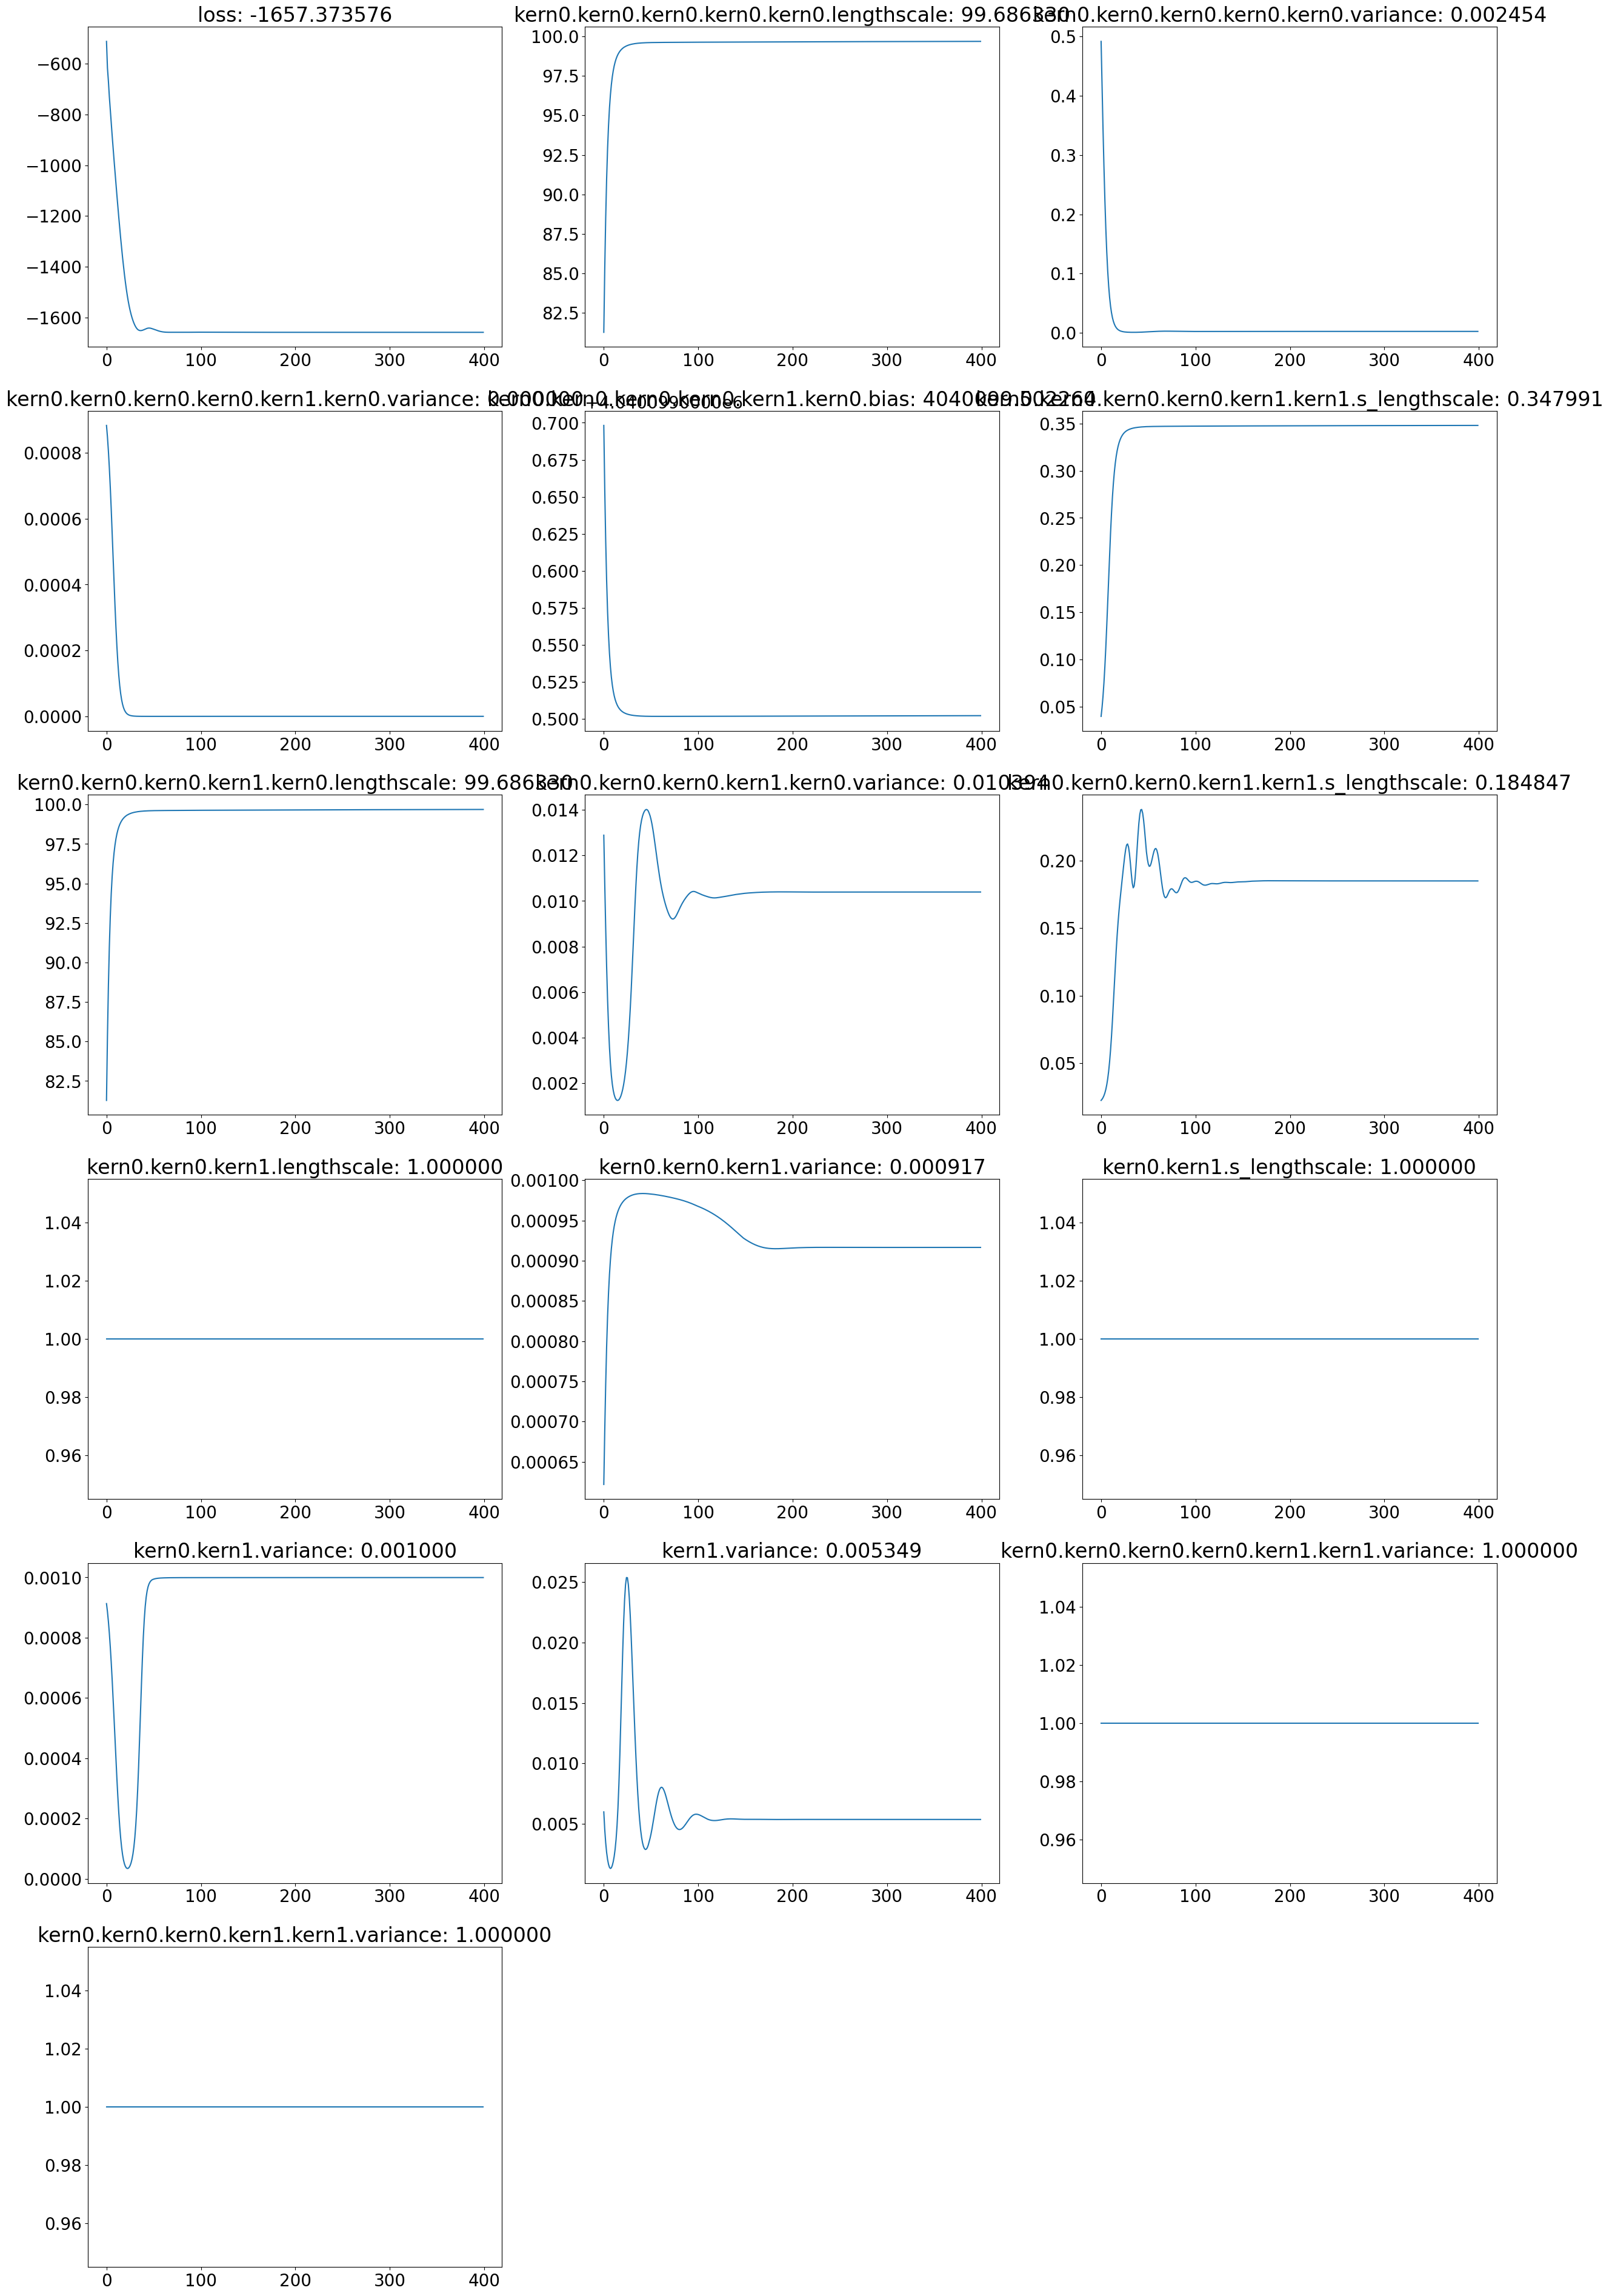

In [39]:
PSTHM.plot_track_list(track_list)

In [23]:
test_age = np.arange(-1000,2020,10)
#generate prediction for one location
data_point = X_all[100,1:]
pred_matrix = PSTHM.gen_pred_matrix(test_age,*data_point)
y_mean, y_var = gpr(pred_matrix, full_cov=True)
y_std = y_var.diag().sqrt()
#-----------------define the kernel to decompose-----------------
test_global_kernel =   gp.kernels.Sum(gpr.kernel.kern0.kern0.kern0.kern0.kern0,gpr.kernel.kern1)
regional_linear_kernel =gpr.kernel.kern0.kern0.kern0.kern0.kern1
regional_nl_kernel = gpr.kernel.kern0.kern0.kern0.kern1

#-----------------decompose the kernel-----------------
global_dep,reigonal_linear_dep,regional_nl_dep = PSTHM.decompose_kernels(gpr,pred_matrix,[test_global_kernel,regional_linear_kernel,regional_nl_kernel])
global_mean,global_var = global_dep
global_std = global_var.diag().sqrt()

regional_linear_mean,regional_linear_var = reigonal_linear_dep
regional_linear_std = regional_linear_var.diag().sqrt()

regional_nl_mean,regional_nl_var = regional_nl_dep
regional_nl_std = regional_nl_var.diag().sqrt()


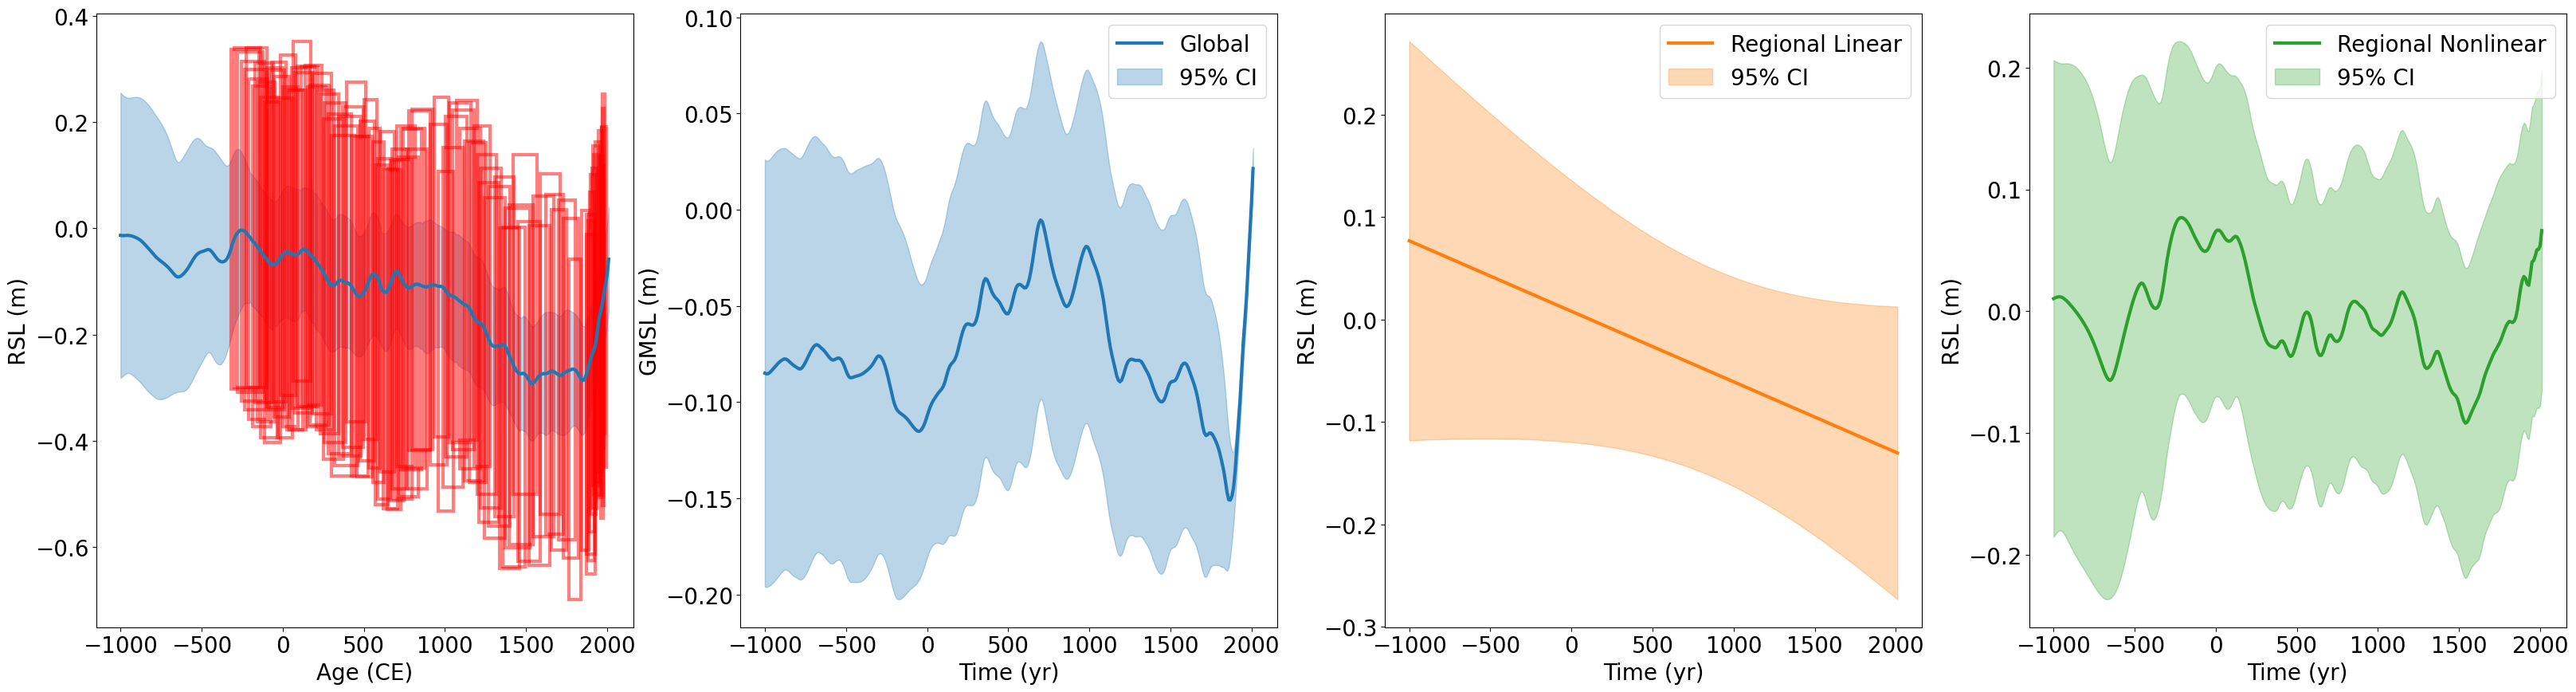

In [24]:
plt.figure(figsize=(40,10))
ax = plt.subplot(141)
data_index = np.sum(np.abs(X_all[:,1:]-data_point),axis=1)<1e-3
PSTHM.plot_uncertainty_boxes(X_all[:,0][data_index],y_no_GIA[data_index], X_sigma[data_index]*2,y_sigma[data_index]*2,ax=ax)
plt.plot(pred_matrix[:,0],y_mean.detach().numpy(),'C0',linewidth=3,label='Mean Prediction')
plt.fill_between(pred_matrix[:,0],y_mean.detach().numpy()-2*y_std.detach().numpy(),y_mean.detach().numpy()+2*y_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.subplot(142)
plt.plot(test_age,global_mean.detach().numpy(),'C0',linewidth=3,label='Global')
plt.fill_between(test_age,global_mean.detach().numpy()-2*global_std.detach().numpy(),global_mean.detach().numpy()+2*global_std.detach().numpy(),color='C0',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('GMSL (m)')
plt.legend()
plt.subplot(143)
plt.plot(test_age,regional_linear_mean.detach().numpy(),'C1',linewidth=3,label='Regional Linear')
plt.fill_between(test_age,regional_linear_mean.detach().numpy()-2*regional_linear_std.detach().numpy(),regional_linear_mean.detach().numpy()+2*regional_linear_std.detach().numpy(),color='C1',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()
plt.subplot(144)
plt.plot(test_age,regional_nl_mean.detach().numpy(),'C2',linewidth=3,label='Regional Nonlinear')
plt.fill_between(test_age,regional_nl_mean.detach().numpy()-2*regional_nl_std.detach().numpy(),regional_nl_mean.detach().numpy()+2*regional_nl_std.detach().numpy(),color='C2',alpha=0.3,label='95% CI')
plt.xlabel('Time (yr)')
plt.ylabel('RSL (m)')
plt.legend()

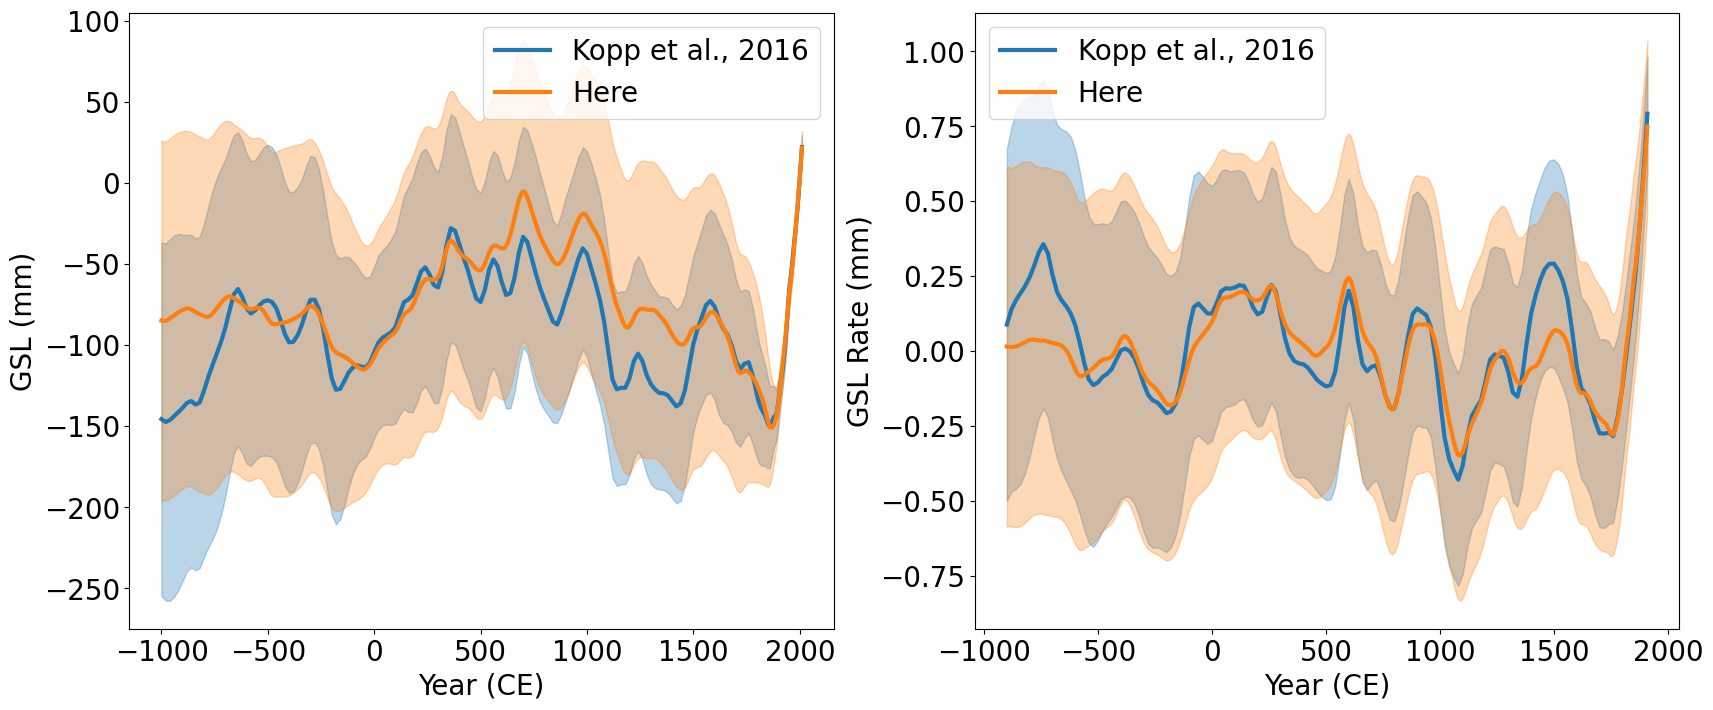

In [50]:
kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy())
kopp2016_rsl_time,kopp2016_rsl_rate,kopp2016_rsl_rate_sd = PSTHM.cal_rate_var(kopp2016['Year'].values,kopp2016_cov,kopp2016['mm'])

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+2*kopp2016['1s'],kopp2016['mm']-2*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-2*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+2*global_std.detach().numpy())*1000,color='C1',alpha=0.3)
plt.ylabel('GSL (mm)')
plt.xlabel('Year (CE)')
plt.legend()

plt.subplot(122)
plt.plot(kopp2016_rsl_time,kopp2016_rsl_rate,label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016_rsl_time,kopp2016_rsl_rate+2*kopp2016_rsl_rate_sd,kopp2016_rsl_rate-2*kopp2016_rsl_rate_sd,alpha=0.3,color='C0')
plt.plot(rsl_time,rsl_rate*1000,label='Here',lw=3)
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,alpha=0.3,color='C1')
plt.ylabel('GSL Rate (mm)')
plt.xlabel('Year (CE)')
plt.legend()

**Using the hyperparameters from Kopp et al., 2016**

In [54]:
pyro.clear_param_store()

gpr.kernel.kern0.kern0.kern0.kern0.kern0.variance = 0.0032832899999999995
gpr.kernel.kern0.kern0.kern0.kern0.kern0.lengthscale = 100

gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern0.variance=1e-6
gpr.kernel.kern0.kern0.kern0.kern0.kern1.kern1.s_lengthscale=0.095

gpr.kernel.kern0.kern0.kern0.kern1.kern1.s_lengthscale = 0.1117010721276371
gpr.kernel.kern0.kern0.kern0.kern1.kern0.variance = 0.00259081
gpr.kernel.kern0.kern0.kern0.kern1.kern0.lengthscale = 100

gpr.kernel.kern0.kern1.variance = 0.00032761000000000004
gpr.kernel.kern0.kern0.kern1.variance = 0.00043680999999999993
gpr.kernel.kern1.variance = torch.tensor(0.014641)

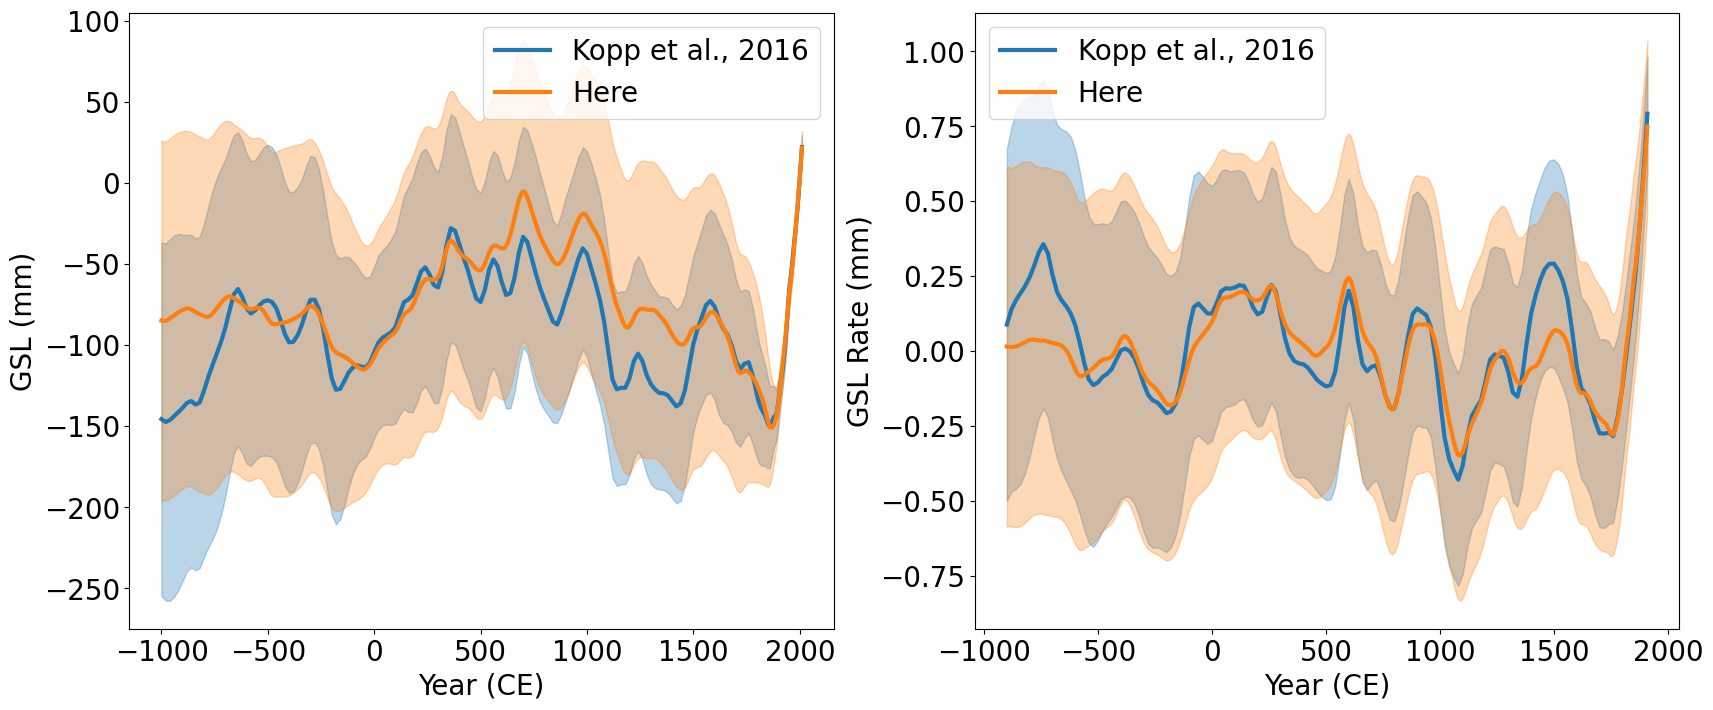

In [55]:
kopp2016 = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=1,skiprows=2)
kopp2016_cov = pd.read_excel('IFILES/Kopp2016.xls',sheet_name=6,skiprows=2).iloc[:,1:]
rsl_time,rsl_rate,rsl_rate_sd = PSTHM.cal_rate_var(pred_matrix[:,0].detach().numpy(),global_var.detach().numpy(),global_mean.detach().numpy())
kopp2016_rsl_time,kopp2016_rsl_rate,kopp2016_rsl_rate_sd = PSTHM.cal_rate_var(kopp2016['Year'].values,kopp2016_cov,kopp2016['mm'])

plt.figure(figsize=(20,8))
plt.subplot(121)
plt.plot(kopp2016['Year'], kopp2016['mm'],label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016['Year'],kopp2016['mm']+2*kopp2016['1s'],kopp2016['mm']-2*kopp2016['1s'],alpha=0.3,color='C0')

plt.plot(test_age,global_mean.detach().numpy()*1000,linewidth=3,label='Here')
plt.fill_between(test_age,(global_mean.detach().numpy()-2*global_std.detach().numpy())*1000,(global_mean.detach().numpy()+2*global_std.detach().numpy())*1000,color='C1',alpha=0.3)
plt.ylabel('GSL (mm)')
plt.xlabel('Year (CE)')
plt.legend()

plt.subplot(122)
plt.plot(kopp2016_rsl_time,kopp2016_rsl_rate,label='Kopp et al., 2016',lw=3)
plt.fill_between(kopp2016_rsl_time,kopp2016_rsl_rate+2*kopp2016_rsl_rate_sd,kopp2016_rsl_rate-2*kopp2016_rsl_rate_sd,alpha=0.3,color='C0')
plt.plot(rsl_time,rsl_rate*1000,label='Here',lw=3)
plt.fill_between(rsl_time,(rsl_rate-2*rsl_rate_sd)*1000,(rsl_rate+2*rsl_rate_sd)*1000,alpha=0.3,color='C1')
plt.ylabel('GSL Rate (mm)')
plt.xlabel('Year (CE)')
plt.legend()